<a href="https://colab.research.google.com/github/Jin-jin-jara/Kaggle-2018-data-science-bowl/blob/master/2018DataScience_(%EC%88%98%EC%A0%95%EC%A4%91).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2018 Kaggle Data Science Bowl

### 캐글과 연동하여 데이터 불러오기

In [0]:
!pip install kaggle
from google.colab import files
files.upload()

In [2]:
!ls -ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

필요한 데이터를 다운로드한다.

In [4]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 52.9MB/s]
 98% 270M/276M [00:02<00:00, 136MB/s]
100% 276M/276M [00:02<00:00, 133MB/s]
 90% 71.0M/79.1M [00:00<00:00, 55.6MB/s]
100% 79.1M/79.1M [00:00<00:00, 102MB/s] 
  0% 0.00/9.10M [00:00<?, ?B/s]
100% 9.10M/9.10M [00:00<00:00, 83.9MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 180MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 118MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 12.4MB/s]


In [0]:
!unzip ../content/stage1_train_labels.csv.zip
!unzip ../content/stage1_train.zip -d stage1_train
!unzip ../content/stage1_test.zip -d stage1_test
!unzip stage1_sample_submission.csv.zip

필요 라이브러리 다운로드

In [0]:
!pip install segmentation_models

In [7]:
pip install tta-wrapper

In [8]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import pathlib
from glob import glob
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap
from skimage.transform import resize
from skimage.filters import threshold_multiotsu
from skimage import filters, data
from skimage.color import rgb2gray
from skimage import transform
import tqdm

# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import ResNet101V2
import random
import cv2

import segmentation_models
# sm.set_framword('tf.keras')
from segmentation_models import get_preprocessing
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss, dice_loss
from segmentation_models.metrics import iou_score

np.random.seed(47)
%matplotlib inline

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [0]:
STAGE1_TRAIN = "../content/stage1_train"
STAGE1_TRAIN_IMAGE = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK = "%s/{}/masks/*.png" % STAGE1_TRAIN
IMAGE_ID = "image_id"
IMAGE_WIDTH = "width"
IMAGE_WEIGHT = "height"
HSV_CLUSTER = "hsv_cluster"
HSV_DOMINANT = "hsv_dominant"
TOTAL_MASK = "total_masks"

# 제출용 파일
submission = pd.read_csv('stage2_sample_submission_final.csv')

## EDA(탐색적 데이터 분석)

사용할 함수들

In [0]:
# 이미지의 고유 id를 리턴
def image_ids_in(root_dir, ignore=[]):
  ids = []
  for id in os.listdir(root_dir):
    if id in ignore:
      print("Skipping ID:", id)
    else:
      ids.append(id)
  return ids

# 이미지를 읽어온다.
def read_image(image_id, space='rgb'):
  image_file = STAGE1_TRAIN_IMAGE.format(image_id, image_id)
  image = skimage.io.imread(image_file) 
  # Alpha 채널은 비어있기 때문에 채널부분은 RGB채널만을 갖는다.
  image = image[:, :, :3]
  if space=='hsv':
    # HSV : rgb2hsv(RGB)는 RGB 이미지의 빨간색, 녹색, 파란색 값을 HSV 이미지의 색상, 채도, 명도(HSV) 값으로 변환한다.
    image = skimage.color.rgb2hsv(image)
  return image

# 각 이미지에 대한 마스크를 가져온다. 이미지와 합쳐진 마스크를 리턴
def read_image_labels(image_id, space='rgb'):
  image = read_image(image_id, space=space)
  mask_file = STAGE1_TRAIN_MASK.format(image_id)
  masks = skimage.io.imread_collection(mask_file).concatenate()
  height, width, _ = image.shape
  num_masks = masks.shape[0]
  labels = np.zeros((height, width), np.uint16)
  for index in range(0, num_masks):
    labels[masks[index] > 0] = 255
  return image, labels, num_masks

# KMeans로 각 이미지들의 dominant color를 구한다. 
def get_dominant_color(img, top_colors=2):
  img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
  clt = KMeans(n_clusters=top_colors)
  clt.fit(img_l)
  # grab the number of different clusters and create a histogram
  # based on the number of pixels assigned to each cluster
  numLabels = np.arange(0, len(np.unique(clt.labels_))+1)
  # clt.labels_ : 각 데이터가 어느 레이블에 속하는지
  (hist, _) = np.histogram(clt.labels_, bins = numLabels)
  # normalize the histogram, such that it sums to one
  hist = hist.astype("float")
  hist /= hist.sum()
  # cluster_centers_ : 해당 군집의 중심위치(즉, 각 군집의 dominant color)
  return clt.cluster_centers_, hist

# 각 이미지의 정보(사이즈, 어떤 이미지 타입으로 분류되는지, 마스크의 개수등)를 리턴한다.
def get_images_details(image_ids):
  details = []
  for image_id in image_ids:
    image_hsv, labels, num_masks = read_image_labels(image_id, space='hsv')
    height, width, l = image_hsv.shape
    dominant_colors_hsv, dominant_rates_hsv = get_dominant_color(image_hsv, top_colors=1)
    dominant_colors_hsv = dominant_colors_hsv.reshape(1, dominant_colors_hsv.shape[0] * dominant_colors_hsv.shape[1])
    info = (image_id, width, height, num_masks, dominant_colors_hsv.squeeze())
    details.append(info)
  
  return details

# 이미지를 화면에 그리는 함수
def plot_images(images, images_rows, images_cols):
  f, axarr = plt.subplots(images_rows, images_cols, figsize=(16, images_rows*2))
  for row in range(images_rows):
    for col in range(images_cols):
      image_id = images[row*images_cols + col]
      image = read_image(image_id)
      height, width, l = image.shape
      ax = axarr[row, col]
      ax.axis('off')
      ax.set_title("%dx%d"%(width, height))
      ax.imshow(image)

# 이미지를 원하는 사이즈로 바꾼다.
def resize_images(ids, image_size=256, space='rgb'): 
  resize_imgs = np.zeros((len(ids), image_size, image_size, 3), dtype=np.uint8)
  resize_masks = np.zeros((len(ids), image_size, image_size),dtype=np.uint8)

  for n, id in enumerate(ids):
    img, labels, _ = read_image_labels(id, space=space)
    i = resize(img, (image_size, image_size), preserve_range=True, mode='constant')
    m = resize(labels, (image_size, image_size), preserve_range=True, mode='constant')
    resize_imgs[n], resize_masks[n] = i, m
  return resize_imgs, resize_masks

이미지의 고유 아이디를 한 리스트에 넣는다.

In [0]:
train_image_ids = image_ids_in(STAGE1_TRAIN)

In [0]:
META_COLS = [IMAGE_ID, IMAGE_WIDTH, IMAGE_WEIGHT, TOTAL_MASK]
COLS = META_COLS + [HSV_DOMINANT]

In [0]:
details = get_images_details(train_image_ids)

In [14]:
trainPD = pd.DataFrame(details, columns=COLS)
X = (pd.DataFrame(trainPD[HSV_DOMINANT].values.tolist())).as_matrix()
kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.predict(X)
trainPD[HSV_CLUSTER] = clusters

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


이미지의 정보를 데이터 프레임으로 한 눈에 볼 수 있게 만든다. 각각의 이미지들이 다른 사이즈를 갖는 것을 볼 수 있다. 또 이미지들마다 갖고 있는 마스크의 개수도 다르다. 

In [15]:
trainPD.head()

,image_id,width,height,total_masks,hsv_dominant,hsv_cluster
0,cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3...,1272,603,250,"[0.0, 0.0, 0.018700307808604297]",0
1,3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075...,256,256,66,"[0.0, 0.0, 0.08116598690257243]",0
2,e23e11414ee645b51081fb202d38b793f0c8ef2940f822...,696,520,199,"[0.0, 0.0, 0.09731008694370719]",0
3,e50ac10d1dce6496d092d966784ed3795969128ca0bc58...,256,256,67,"[0.0, 0.0, 0.07626258999693729]",0
4,98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70b...,696,520,125,"[0.0, 0.0, 0.030255846812648975]",0


스테이지 1의 이미지들을 dominant color에 따라 분류하면 세 그룹으로 묶인다. KMeans로 분류한 이미지들을 살펴보자. dominant color에 대한 자세한 설명은 <a href="https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/">여기</a>를 참고. 첫 번째 그룹은 histological slides(어떤 세포 조직의 단면), 두 번째 그룹은 fluorescent images(형광 이미지?), 세 번째 그룹은 bright-field images.

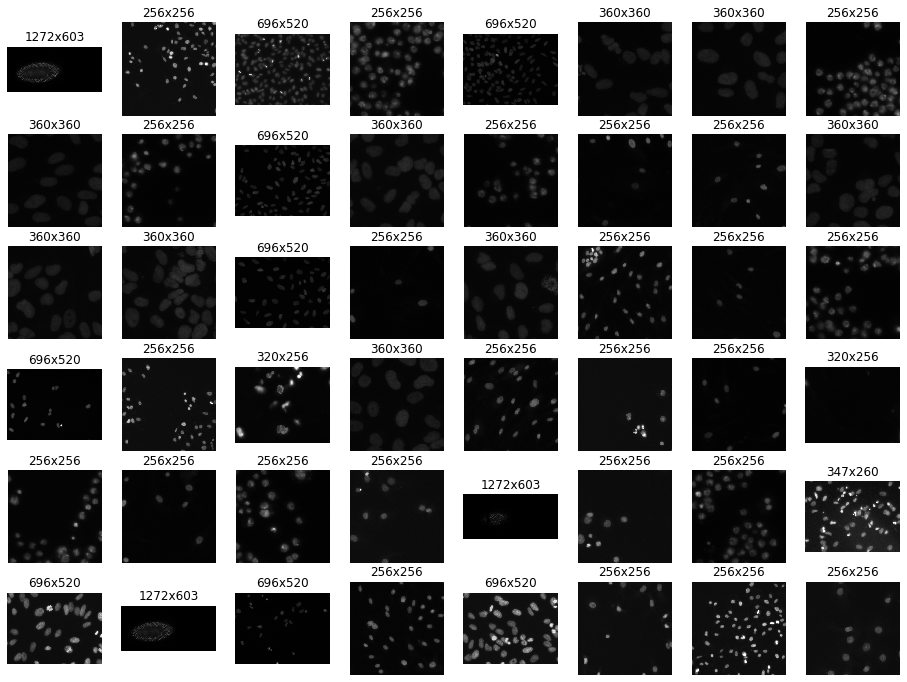

In [16]:
# 첫 번째 이미지 그룹
plot_images(trainPD[trainPD[HSV_CLUSTER]==0][IMAGE_ID].values, 6, 8)

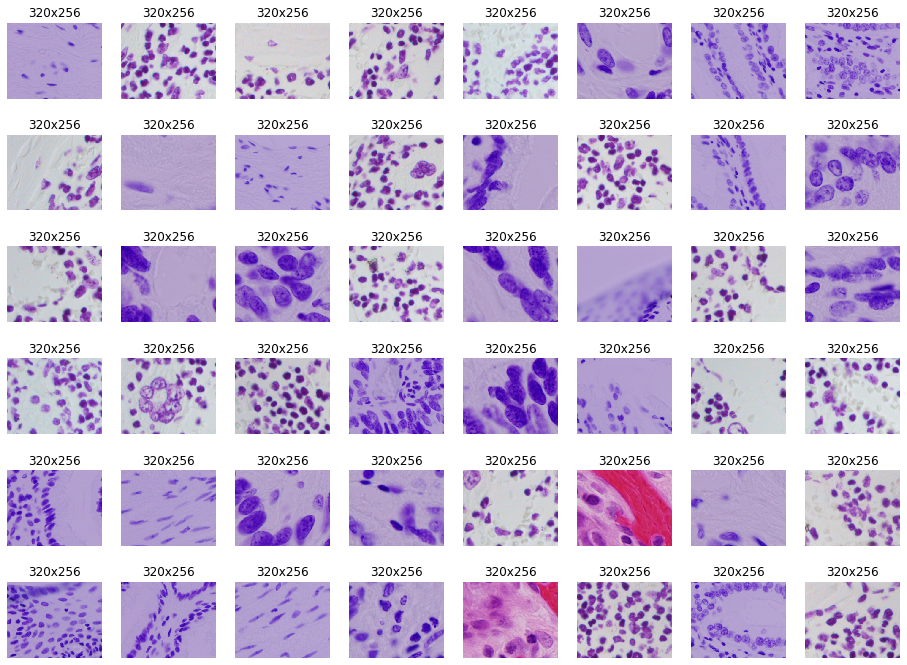

In [17]:
# 두 번째 이미지 그룹
plot_images(trainPD[trainPD[HSV_CLUSTER]==1][IMAGE_ID].values, 6, 8)

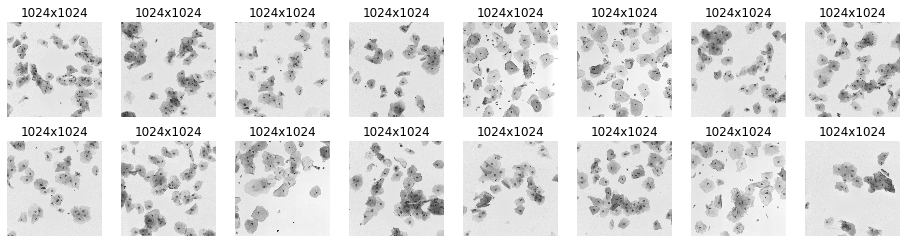

In [18]:
# 세 번째 이미지 그룹
plot_images(trainPD[trainPD[HSV_CLUSTER]==2][IMAGE_ID].values, 2, 8)

이미지 그룹들의 비율을 보면, 두 번째 이미지 그룹이 가장 큰 비중을 차지한다. 

In [19]:
P = trainPD.groupby(HSV_CLUSTER)[IMAGE_ID].count().reset_index()
P['Percentage'] = 100*P[IMAGE_ID]/P[IMAGE_ID].sum()
P

,hsv_cluster,image_id,Percentage
0,0,546,81.492537
1,1,108,16.119403
2,2,16,2.388060


In [0]:
def plot_image_masks(image, labels, num_masks, image_id):
    f, ax = plt.subplots(1,3,figsize=(16,5))
    d = ax[0].axis('off')
    d = ax[0].imshow(image)
    d = ax[0].set_title("\n".join(wrap(image_id, 32)))
    d = ax[1].axis('off')
    d = ax[1].imshow(labels)
    d = ax[1].set_title("masks: %d"%num_masks)
    d = ax[2].axis('off')
    d = ax[2].imshow(image)
    d = ax[2].imshow(labels, alpha=0.5)
    d = ax[2].set_title("both")

In [0]:
def display_image_masks(image_id):
    image, labels, num_masks = read_image_labels(image_id)
    plot_image_masks(image, labels, num_masks, image_id)

In [0]:
display_image_masks(train_image_ids[8])

이미지들의 크기가 전부 다르기 때문에 제일 작은 사이즈인 256x256로 전부 맞춰준다.

In [0]:
X_train, y_train = resize_images(train_image_ids, image_size=256)

데이터를 train세트와 validation 세트로 나눠준다.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val,  y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [22]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((536, 256, 256, 3), (536, 256, 256), (134, 256, 256, 3), (134, 256, 256))

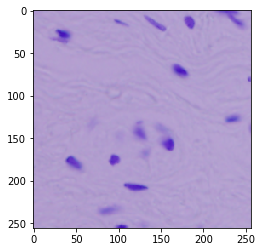

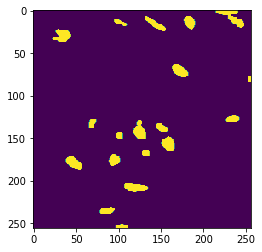

In [23]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(y_train[0])
plt.show()

## build model

In [0]:
BACKBONE = 'efficientnetb6'
preprocess_input = get_preprocessing(BACKBONE)

주어진 이미지 데이터의 개수는 670개로 훈련 시키기에는 데이터셋이 너무 작기 때문에 augmentation으로 데이터를 늘려준다. ImageDataGenerator 라이브러리를 사용해도 되지만 generator를 커스텀하기 위해서 albumentations 라이브러리를 사용했다.<br><br>
albumentations : 데이터 augmentation을 튜닝할 수 있는 함수. 파이프라인 generator를 만들어 같이 사용한다.

In [80]:
from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
%load_ext autoreload
%autoreload 2
%matplotlib inline
# 라이브러리에서 원하는 필터를 골라 적용할 수 있다.
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
 
import albumentations as albu
from albumentations import Resize

# 파이프라인 generator 클래스 생성
class MyGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentation, data_type="train"):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentation
        self.image_size = 256
        self.data_type = data_type
        self.indice = None
        self.shuffle = shuffle
        
    def __len__(self):
        """
        배치 사이즈를 계산
        """
        return int(np.ceil(len(self.x) / (self.batch_size)))

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        if self.shuffle==True:
            self.x, self.y = shuffle(self.x, self.y)

    def read_image_mask(self, img, mask):
        return img, rgb2gray(mask).astype(np.uint8)

    def __getitem__(self, index):
        """
        Generate one batch of data
        
        """
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.x)))
        
        indice = self.x[data_index_min:data_index_max]

        this_batch_size = len(indice) # The last batch can be smaller than the others
        
        # Defining dataset
        X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.uint8)
        Y = np.empty((this_batch_size, self.image_size, self.image_size, 1), dtype=np.uint8)

        for i, sample_index in enumerate(indice):

            X_sample, y_sample = self.read_image_mask(self.x[index * self.batch_size + i], self.y[index * self.batch_size + i])
            # 데이터셋이 train이면 이미지 augmentation을 수행한다.
            if self.data_type == "train":
                  
              # Augmentation code
              augmented = self.augment(self.image_size)(image=X_sample, mask=y_sample)
              image_augm = augmented['image']
              mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, 1)
              X[i, ...] = image_augm
              Y[i, ...] = mask_augm
                
            # test 데이터셋이면 augmentation는 수행하지 않고 그냥 생성한다.
            elif self.data_type == "test":
              X[i, ...] = X_sample
              Y[i, ...] = y_sample.reshape(self.image_size, self.image_size, 1)
              
        return X, Y[:,:,:,:1]/255
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


데이터 augmentation 함수 만들기

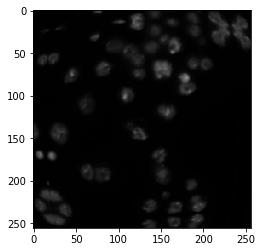

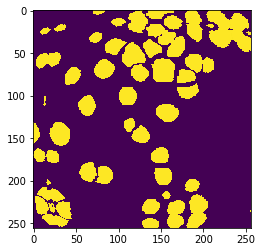

In [81]:
# 데이터 augmentation 함수 : 원하는 필터를 넣으면 된다. p는 확률
def augmentation(image_size = 256):
    return Compose([
        # HorizontalFlip(p=1),
        # VerticalFlip(p=1),
        # RandomRotate90(p=1),
        IAASharpen(p=1),
        RandomContrast(p=1),
        # Transpose(p=0.5),
        # ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=1),
        RandomGamma(p=1),
        IAAEmboss(p=1),
        RGBShift(p=0.5),
        Blur(p=1, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

# 함수와 파이프라인이 잘 작동되는지 테스트
batch_size=16
test_generator = MyGenerator(X_train, y_train, batch_size, augmentation = augmentation)
Xtest, ytest = test_generator.__getitem__(8)
# 테스트 이미지
plt.imshow(Xtest[0])     
plt.show()
# 테스트 마스크
plt.imshow(ytest[0, :,:,0])
plt.show()

train generator와 test generator 생성

In [0]:
train_gen = MyGenerator(X_train, y_train, 16, augmentation=augmentation)
test_gen = MyGenerator(X_val, y_val, 16, augmentation=augmentation, data_type="test")

## 모델 생성

### callbacks

In [0]:
# plateau는 정체기란 뜻으로 모델의 정확도가 향상되지 않는 경우 ㅡ learning rate (lr) 을 줄여주는 클래스
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=10,
                               patience=10, verbose=1,
                               min_lr=0.1e-5)

# 학습 과정 중 콜백을 사용해서 모델의 내적 상태와 통계자료를 확인 할 수 있다
# ModelCheckpoint 콜백 함수는 Keras에서 모델을 학습할 때마다 중간중간에 콜백 형태로 알려준다.
# mode_autosave = ModelCheckpoint("content/resnet101.h5", monitor='val_iou_score',
#                                 mode='max', save_best_only=True, verbose=1, period=10)

early_stopping = EarlyStopping(patience=10, verbose=1, mode='auto')

# TensorBoard는 TensorFlow에 기록된 로그를 그래프로 시각화시켜서 보여주는 도구
# tensorboard = TensorBoard(log_dir='content/tensorboard', histogram_freq=0,
#                           write_graph=True, write_images=False)
callbacks = [lr_reducer, early_stopping]

## model1 : augmentation no flip

Epoch 1/30
33/34 [============================>.] - ETA: 2s - loss: 1.0471 - iou_score: 0.2706

34/34 [==============================] - 86s 3s/step - loss: 1.0371 - iou_score: 0.2741 - val_loss: 0.7105 - val_iou_score: 0.4040
Epoch 2/30
34/34 [==============================] - 19s 569ms/step - loss: 0.5951 - iou_score: 0.4384 - val_loss: 0.4563 - val_iou_score: 0.5373
Epoch 3/30
34/34 [==============================] - 19s 571ms/step - loss: 0.3774 - iou_score: 0.5969 - val_loss: 0.3171 - val_iou_score: 0.6600
Epoch 4/30
34/34 [==============================] - 19s 572ms/step - loss: 0.3071 - iou_score: 0.6733 - val_loss: 0.2782 - val_iou_score: 0.6989
Epoch 5/30
34/34 [==============================] - 19s 570ms/step - loss: 0.2787 - iou_score: 0.7021 - val_loss: 0.2745 - val_iou_score: 0.7199
Epoch 6/30
34/34 [==============================] - 19s 561ms/step - loss: 0.2710 - iou_score: 0.7159 - val_loss: 0.2765 - val_iou_score: 0.7100
Epoch 7/30
34/34 [==============================

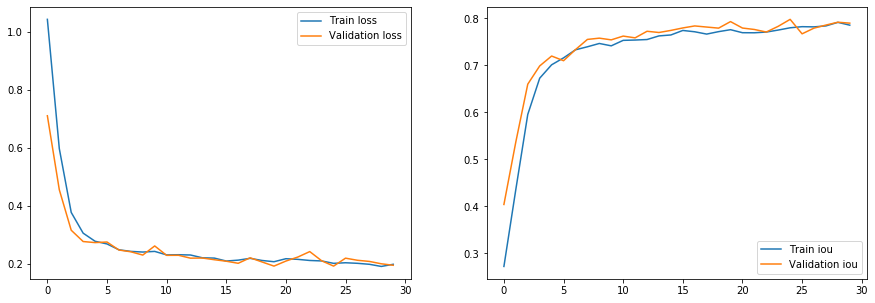

In [87]:
# train데이터와 vailadation 데이터의 손실값, iou점수를 기록하는 함수
def plot_training_history(history):
  fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15, 5))
  ax_loss.plot(history.epoch, history.history['loss'], label="Train loss")
  ax_loss.plot(history.epoch, history.history['val_loss'], label="Validation loss")
  ax_loss.legend()
  ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
  ax_acc.plot(history.epoch, history.history['val_iou_score'], label="Validation iou")
  ax_acc.legend()

# Unet모델. 전이학습 모델로는 efficientnetb6을 사용
model = Unet(backbone_name='efficientnetb6', encoder_weights='imagenet', encoder_freeze=True, decoder_use_batchnorm=True,)
model.compile(optimizer = Adam(),
              loss = bce_dice_loss, metrics=[iou_score])
history = model.fit_generator(train_gen, shuffle=True,
                              epochs=30, workers=4, use_multiprocessing=True,
                              validation_data = test_gen,
                              verbose=1, callbacks=callbacks)

plot_training_history(history)

### Model quality check - single image

In [0]:
def iou_metric(y_true_in, y_pred_in):
  labels = y_true_in
  y_pred = y_pred_in

  temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins = ([0,0.5,1],[0, 0.5, 1]))
  
  intersection = temp1[0]

  area_true = np.histogram(labels, bins = [0, 0.5,1])[0]
  area_pred = np.histogram(y_pred, bins=[0, 0.5, 1])[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)

  union = area_true + area_pred - intersection

  intersection = intersection[1:, 1:]
  intersection[intersection == 0] = 1e-9

  union = union[1:, 1:]
  union[union == 0] = 1e-9

  iou = intersection / union
  return iou

def plot_mask_gt_image(predicted, mask, img):
  fig, axs = plt.subplots(1, 3, figsize=(20, 10))
  axs[0].imshow(predicted, cmap='Blues')
  axs[0].set_title("Predicted")
  axs[0].axis('off')
  axs[1].imshow(mask, cmap="Blues")
  axs[1].set_title("Mask")
  axs[1].axis('off')
  axs[2].imshow(img)
  axs[2].set_title("Original Image")
  axs[2].axis('off')
  plt.show()

def iou_metric_batch(y_true_in, y_pred_in):
  y_pred_in = y_pred_in
  batch_size = y_true_in.shape[0]
  metric = []
  for batch in range(batch_size):
    value = iou_metric(y_true_in[batch], y_pred_in[batch])
    metric.append(value)
  return np.mean(metric)

In [89]:
Xtest, ytest = test_generator.__getitem__(16)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(256, 256)
print('IOU', iou_metric(ytest[0], predicted))

IOU [[0.88591126]]


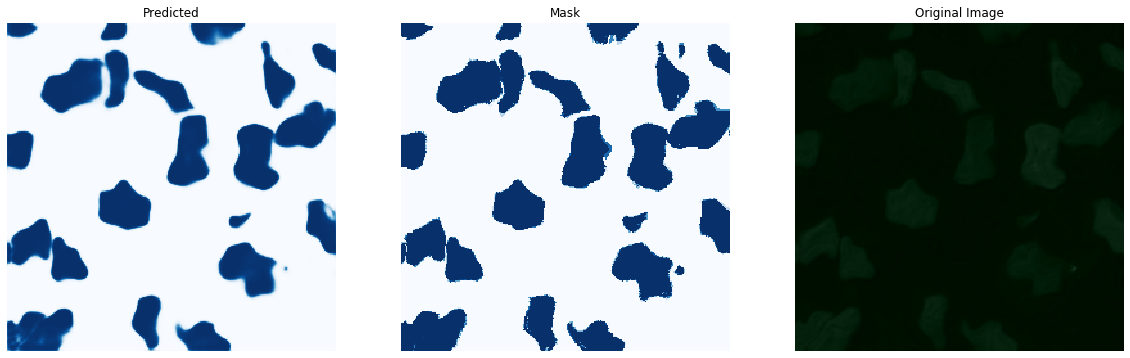

In [99]:
plot_mask_gt_image(predicted, ytest[0].squeeze(-1), Xtest[0])

### Overall quality

In [91]:
scores = model.evaluate_generator(test_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
  print('mean {}: {:.5}'.format(metric.__name__, value))

Loss: 0.19866
mean iou_score: 0.78284


## model2 : augmentaion flipped

In [0]:
# 데이터 augmentation 함수 : 원하는 필터를 넣으면 된다. p는 확률
def augmentation(image_size = 256):
    return Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        IAASharpen(p=0.5),
        RandomContrast(p=0.5),
        # Transpose(p=0.5),
        # ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=1),
        RandomGamma(p=1),
        IAAEmboss(p=1),
        RGBShift(p=0.5),
        Blur(p=1, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

Epoch 1/30
34/34 [==============================] - 97s 3s/step - loss: 0.7714 - iou_score: 0.3742 - val_loss: 0.4864 - val_iou_score: 0.5303
Epoch 2/30
34/34 [==============================] - 19s 559ms/step - loss: 0.4059 - iou_score: 0.5753 - val_loss: 0.3667 - val_iou_score: 0.6160
Epoch 3/30
34/34 [==============================] - 20s 588ms/step - loss: 0.3113 - iou_score: 0.6656 - val_loss: 0.2929 - val_iou_score: 0.6962
Epoch 4/30
34/34 [==============================] - 20s 580ms/step - loss: 0.2790 - iou_score: 0.7015 - val_loss: 0.2921 - val_iou_score: 0.6943
Epoch 5/30
34/34 [==============================] - 19s 572ms/step - loss: 0.2695 - iou_score: 0.7160 - val_loss: 0.3368 - val_iou_score: 0.6669
Epoch 6/30
34/34 [==============================] - 20s 577ms/step - loss: 0.2560 - iou_score: 0.7301 - val_loss: 0.2430 - val_iou_score: 0.7508

Epoch 7/30
34/34 [==============================] - 20s 584ms/step - loss: 0.2463 - iou_score: 0.7396 - val_loss: 0.2443 - val_iou_s

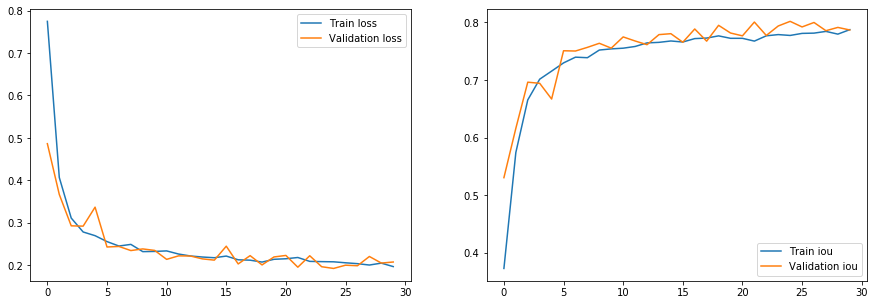

In [102]:
# train데이터와 vailadation 데이터의 손실값, iou점수를 기록하는 함수
def plot_training_history(history):
  fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15, 5))
  ax_loss.plot(history.epoch, history.history['loss'], label="Train loss")
  ax_loss.plot(history.epoch, history.history['val_loss'], label="Validation loss")
  ax_loss.legend()
  ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
  ax_acc.plot(history.epoch, history.history['val_iou_score'], label="Validation iou")
  ax_acc.legend()

# Unet모델. 전이학습 모델로는 efficientnetb6을 사용
model = Unet(backbone_name='efficientnetb6', encoder_weights='imagenet', encoder_freeze=True, decoder_use_batchnorm=True,)
model.compile(optimizer = Adam(),
              loss = bce_dice_loss, metrics=[iou_score])
history = model.fit_generator(train_gen, shuffle=True,
                              epochs=30, workers=4, use_multiprocessing=True,
                              validation_data = test_gen,
                              verbose=1, callbacks=callbacks)

plot_training_history(history)

### Model quality check - single image

In [0]:
def iou_metric(y_true_in, y_pred_in):
  labels = y_true_in
  y_pred = y_pred_in

  temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins = ([0,0.5,1],[0, 0.5, 1]))
  
  intersection = temp1[0]

  area_true = np.histogram(labels, bins = [0, 0.5,1])[0]
  area_pred = np.histogram(y_pred, bins=[0, 0.5, 1])[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)

  union = area_true + area_pred - intersection

  intersection = intersection[1:, 1:]
  intersection[intersection == 0] = 1e-9

  union = union[1:, 1:]
  union[union == 0] = 1e-9

  iou = intersection / union
  return iou

def plot_mask_gt_image(predicted, mask, img):
  fig, axs = plt.subplots(1, 3, figsize=(20, 10))
  axs[0].imshow(predicted, cmap='Blues')
  axs[0].set_title("Predicted")
  axs[0].axis('off')
  axs[1].imshow(mask, cmap="Blues")
  axs[1].set_title("Mask")
  axs[1].axis('off')
  axs[2].imshow(img)
  axs[2].set_title("Original Image")
  axs[2].axis('off')
  plt.show()

def iou_metric_batch(y_true_in, y_pred_in):
  y_pred_in = y_pred_in
  batch_size = y_true_in.shape[0]
  metric = []
  for batch in range(batch_size):
    value = iou_metric(y_true_in[batch], y_pred_in[batch])
    metric.append(value)
  return np.mean(metric)

In [108]:
Xtest, ytest = test_generator.__getitem__(16)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(256, 256)
print('IOU', iou_metric(ytest[0], predicted))

IOU [[0.91882002]]


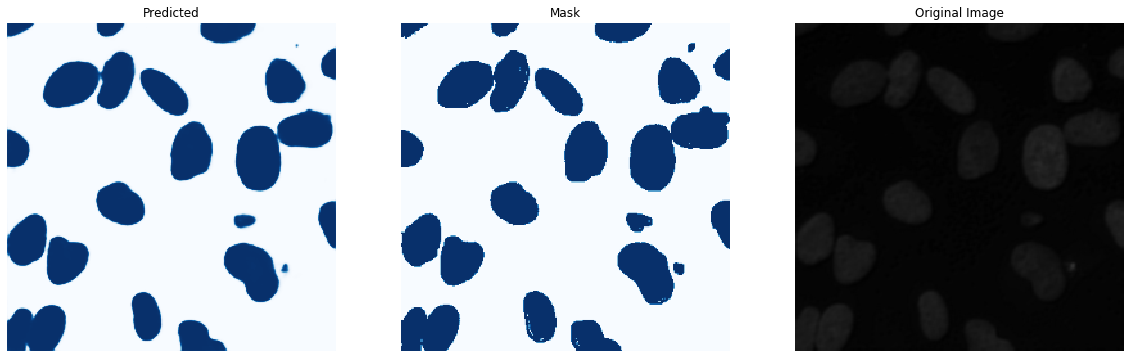

In [0]:
plot_mask_gt_image(predicted, ytest[0].squeeze(-1), Xtest[0])

### Overall quality

In [109]:
scores = model.evaluate_generator(test_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
  print('mean {}: {:.5}'.format(metric.__name__, value))

Loss: 0.20773
mean iou_score: 0.77905


## model3 : no flip, loss = dice_loss

In [0]:
# 데이터 augmentation 함수 : 원하는 필터를 넣으면 된다. p는 확률
def augmentation(image_size = 256):
    return Compose([
        # HorizontalFlip(p=1),
        # VerticalFlip(p=1),
        # RandomRotate90(p=1),
        IAASharpen(p=1),
        RandomContrast(p=1),
        # Transpose(p=0.5),
        # ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=1),
        RandomGamma(p=1),
        IAAEmboss(p=1),
        RGBShift(p=0.5),
        Blur(p=1, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

Epoch 1/30
34/34 [==============================] - 105s 3s/step - loss: 0.6005 - iou_score: 0.2516 - val_loss: 0.5075 - val_iou_score: 0.3277
Epoch 1/30
Epoch 2/30
34/34 [==============================] - 19s 572ms/step - loss: 0.4089 - iou_score: 0.4267 - val_loss: 0.3130 - val_iou_score: 0.5241
Epoch 3/30
34/34 [==============================] - 20s 603ms/step - loss: 0.2355 - iou_score: 0.6223 - val_loss: 0.2077 - val_iou_score: 0.6569
Epoch 4/30
34/34 [==============================] - 20s 577ms/step - loss: 0.1720 - iou_score: 0.7080 - val_loss: 0.1693 - val_iou_score: 0.7108
Epoch 5/30
34/34 [==============================] - 20s 585ms/step - loss: 0.1490 - iou_score: 0.7417 - val_loss: 0.1442 - val_iou_score: 0.7483
Epoch 6/30
34/34 [==============================] - 20s 602ms/step - loss: 0.1402 - iou_score: 0.7553 - val_loss: 0.1400 - val_iou_score: 0.7546
Epoch 7/30
34/34 [==============================] - 20s 582ms/step - loss: 0.1325 - iou_score: 0.7670 - val_loss: 0.1354 

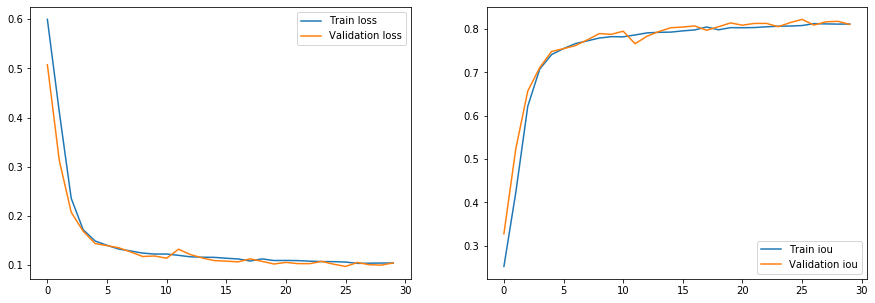

In [112]:
# train데이터와 vailadation 데이터의 손실값, iou점수를 기록하는 함수
def plot_training_history(history):
  fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15, 5))
  ax_loss.plot(history.epoch, history.history['loss'], label="Train loss")
  ax_loss.plot(history.epoch, history.history['val_loss'], label="Validation loss")
  ax_loss.legend()
  ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
  ax_acc.plot(history.epoch, history.history['val_iou_score'], label="Validation iou")
  ax_acc.legend()

# Unet모델. 전이학습 모델로는 efficientnetb6을 사용
model = Unet(backbone_name='efficientnetb6', encoder_weights='imagenet', encoder_freeze=True, decoder_use_batchnorm=True,)
model.compile(optimizer = Adam(),
              loss = dice_loss, metrics=[iou_score])
history = model.fit_generator(train_gen, shuffle=True,
                              epochs=30, workers=4, use_multiprocessing=True,
                              validation_data = test_gen,
                              verbose=1, callbacks=callbacks)
# 
plot_training_history(history)

### Model quality check - single image

In [0]:
def iou_metric(y_true_in, y_pred_in):
  labels = y_true_in
  y_pred = y_pred_in

  temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins = ([0,0.5,1],[0, 0.5, 1]))
  
  intersection = temp1[0]

  area_true = np.histogram(labels, bins = [0, 0.5,1])[0]
  area_pred = np.histogram(y_pred, bins=[0, 0.5, 1])[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)

  union = area_true + area_pred - intersection

  intersection = intersection[1:, 1:]
  intersection[intersection == 0] = 1e-9

  union = union[1:, 1:]
  union[union == 0] = 1e-9

  iou = intersection / union
  return iou

def plot_mask_gt_image(predicted, mask, img):
  fig, axs = plt.subplots(1, 3, figsize=(20, 10))
  axs[0].imshow(predicted, cmap='Blues')
  axs[0].set_title("Predicted")
  axs[0].axis('off')
  axs[1].imshow(mask, cmap="Blues")
  axs[1].set_title("Mask")
  axs[1].axis('off')
  axs[2].imshow(img)
  axs[2].set_title("Original Image")
  axs[2].axis('off')
  plt.show()

def iou_metric_batch(y_true_in, y_pred_in):
  y_pred_in = y_pred_in
  batch_size = y_true_in.shape[0]
  metric = []
  for batch in range(batch_size):
    value = iou_metric(y_true_in[batch], y_pred_in[batch])
    metric.append(value)
  return np.mean(metric)

In [117]:
Xtest, ytest = test_generator.__getitem__(16)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(256, 256)
print('IOU', iou_metric(ytest[0], predicted))

IOU [[0.9064941]]


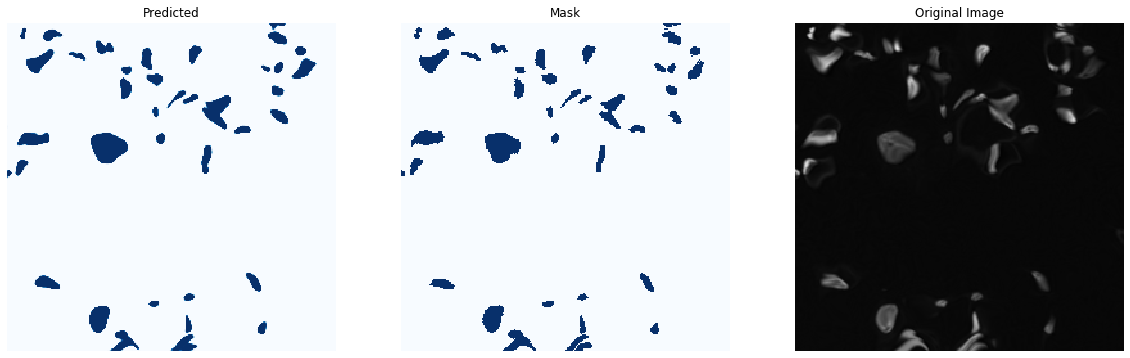

In [115]:
plot_mask_gt_image(predicted, ytest[0].squeeze(-1), Xtest[0])

### Overall quality

In [118]:
scores = model.evaluate_generator(test_generator)
metrics=[iou_score]
print('Loss:{:.5}'.format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
  print("mean {}: {:.5}".format(metric.__name__, value))

Loss:0.10511
mean iou_score: 0.81022


## model 결론
1) 데이터 augmentation 과정에서 Flip이나 Rotate은 넣든 안넣든 비슷하다.<br>
2) loss function으론 bce_dice_loss와 dice_loss중 dice_loss가 더 나은 성능 보여준다.<br>


In [0]:
resized_masks = []
for n, id_ in enumerate(test_ids):
  image = read_test_image(id_)
  h, w = image.shape[0], image.shape[1]
  resized = resize(predict[n], (h, w), mode='constant', preserve_range=True)
  resized = np.where(resized>0.5, 1, 0).astype(np.bool)
  resized_masks.append(resized)

In [0]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [0]:
rle = list(map(rle_encoding, resized_masks))

In [0]:
# submission['EncodedPixels'] = result
submission.head(10)

In [0]:
submission['EncodedPixels'] = rle
submission.head()

In [0]:
submission.to_csv('test05.csv', index=False)